In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path

In [2]:
from dask.distributed import Client

In [3]:
import numpy as np

In [4]:
import cartopy.crs as ccrs

In [5]:
client = Client(n_workers=3, threads_per_worker=4, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39571 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:39571/status,
Dashboard: http://134.245.3.15:39571/status,Workers: 3
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:38987,Workers: 3
Dashboard: http://134.245.3.15:39571/status,Total threads: 12
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://134.245.3.15:39565,Total threads: 4
Dashboard: http://134.245.3.15:46657/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:36033,


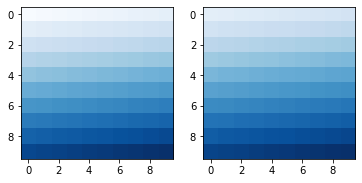

In [6]:
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.1, 1)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [7]:
plt.rcParams.update({'font.size': 18})

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
data_path = "/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/"
experiment_name = "INALT20.L46-KFS119"
data_resolution = '1d'

lat_top = -21.5
lat_bottom = -25
lon_left = 7
lon_right = 10

fname_U = f'1_{experiment_name}_{data_resolution}_20*_grid_U*.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_20*_grid_V*.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_20*_grid_W*.nc'

mask_path = Path("/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/")
mesh_mask_filename = '1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc'
mesh_mask = mask_path / mesh_mask_filename

In [10]:
data_path = Path(data_path)
files_U = list(sorted((data_path).glob(fname_U)))
files_V = list(sorted((data_path).glob(fname_V)))
files_W = list(sorted((data_path).glob(fname_W)))

In [11]:
ds_u = xr.open_mfdataset(files_U, chunks={"x": "auto", "y": "auto", "time_counter": "auto", "depthu": "auto"})
ds_v = xr.open_mfdataset(files_V, chunks={"x": "auto", "y": "auto", "time_counter": "auto", "depthv": "auto"})
ds_w = xr.open_mfdataset(files_W, chunks={"x": "auto", "y": "auto", "time_counter": "auto", "depthw": "auto"})
ds_mask = xr.open_dataset(mesh_mask)

In [30]:
u = ds_u["vozocrtx"].where(
     (ds_u.nav_lat >= lat_bottom-1) & (ds_u.nav_lat <= lat_top+1) \
     & (ds_u.nav_lon >= lon_left-1.05) & (ds_u.nav_lon <= lon_right+1), drop=True)#.sel(time_counter=slice('2009-03-01T12:00:00','2009-04-13T12:00:00'))

In [31]:
v = ds_v["vomecrty"].where(
     (ds_v.nav_lat >= lat_bottom-0.95) & (ds_v.nav_lat <= lat_top+1) \
     & (ds_v.nav_lon >= lon_left-1) & (ds_v.nav_lon <= lon_right+1), drop=True)#.sel(time_counter=slice('2009-03-01T12:00:00','2009-04-13T12:00:00'))

In [32]:
w = ds_w["vovecrtz"].where(
     (ds_w.nav_lat >= lat_bottom-1) & (ds_w.nav_lat <= lat_top+1) \
     & (ds_w.nav_lon >= lon_left-1) & (ds_w.nav_lon <= lon_right+1), drop=True)#.sel(time_counter=slice('2009-03-01T12:00:00','2009-04-13T12:00:00'))

In [33]:
mask = ds_mask["umask"].isel(z=0).where(
    (ds_u.nav_lat >= lat_bottom-1) & (ds_u.nav_lat <= lat_top+1) \
    & (ds_u.nav_lon >= lon_left-1.05) & (ds_u.nav_lon <= lon_right+1), drop=True
)

In [34]:
mask

<xarray.DataArray 'umask' (t: 1, y: 119, x: 101)>
dask.array<where, shape=(1, 119, 101), dtype=float64, chunksize=(1, 119, 101), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(119, 101), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(119, 101), meta=np.ndarray>
Dimensions without coordinates: t, y, x

In [35]:
u = u.rename("u").rename({"depthu": "depth"})
v = v.rename("v").rename({"depthv": "depth"})
w = w.rename("w").rename({"depthw": "depth"});

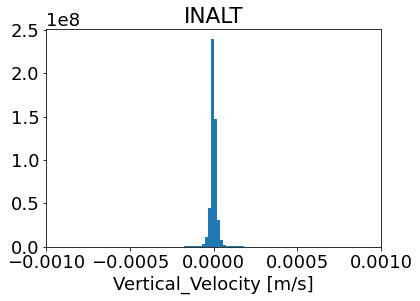

In [36]:
w.plot.hist(bins=250)
plt.xlim([-0.001,0.001])
plt.title('INALT');

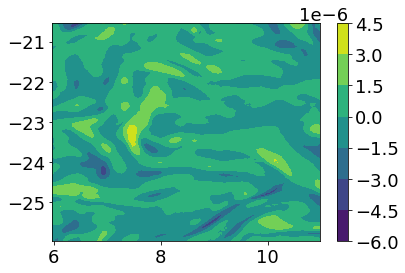

In [37]:
cf=plt.contourf(mask.nav_lon[0,:],mask.nav_lat[:,0],w.isel(time_counter=0,depth=1))
cb=plt.colorbar(cf)

In [38]:
w['depth']=v['depth']

In [39]:
vel = xr.combine_by_coords([u, v], compat='override', combine_attrs='drop_conflicts')

In [40]:
vel["vel"] = np.sqrt(vel.u**2 + vel.v**2)

In [42]:
%%time

vel = vel.compute()

2023-09-18 11:12:14,157 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.34 GiB -- Worker memory limit: 7.45 GiB
2023-09-18 11:12:14,158 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.34 GiB -- Worker memory limit: 7.45 GiB
2023-09-18 11:12:14,160 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

CPU times: user 3min 22s, sys: 20.5 s, total: 3min 42s
Wall time: 20min 57s


In [43]:
vel

<xarray.Dataset>
Dimensions:        (depth: 46, y: 119, x: 101, time_counter: 1096)
Coordinates:
  * depth          (depth) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (y, x) float32 -25.96 -25.96 -25.96 ... -20.55 -20.55 -20.55
    nav_lon        (y, x) float32 5.975 6.025 6.075 6.125 ... 10.88 10.93 10.98
    time_centered  (time_counter) datetime64[ns] 2008-01-01T12:00:00 ... 2010...
  * time_counter   (time_counter) datetime64[ns] 2008-01-01T12:00:00 ... 2010...
Dimensions without coordinates: y, x
Data variables:
    u              (time_counter, depth, y, x) float32 -0.01401 -0.013 ... 0.0
    v              (time_counter, depth, y, x) float32 0.0773 0.08723 ... 0.0
    vel            (time_counter, depth, y, x) float32 0.07856 0.0882 ... 0.0

In [44]:
vel_w = xr.combine_by_coords([u, v, w], compat='override', combine_attrs='drop_conflicts')

In [45]:
vel_w["vel"] = np.sqrt(vel_w.u**2 + vel_w.v**2 + vel_w.w**2)

In [ ]:
%%time

vel_w = vel_w.compute()

2023-09-18 11:12:44,022 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.23 GiB -- Worker memory limit: 7.45 GiB
2023-09-18 11:12:44,024 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.23 GiB -- Worker memory limit: 7.45 GiB
2023-09-18 11:12:44,049 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [ ]:
vel_w

In [29]:
vel_w_plot = vel_w.isel(y=60, x=slice(40,70,None),time_counter=0)#.where(vel_w.depth < 2050,drop = True)

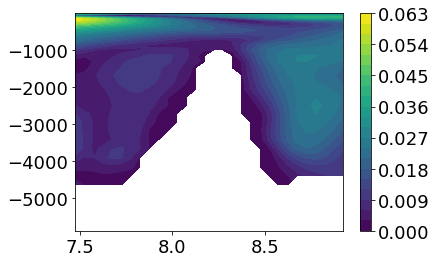

In [30]:
cf = plt.contourf(vel_w_plot['nav_lon'],-vel_w_plot['depth'],vel_w_plot.vel,levels=20)
cb = plt.colorbar()

In [31]:
vel_quiver = vel.mean('time_counter')#.isel(time_counter=0)

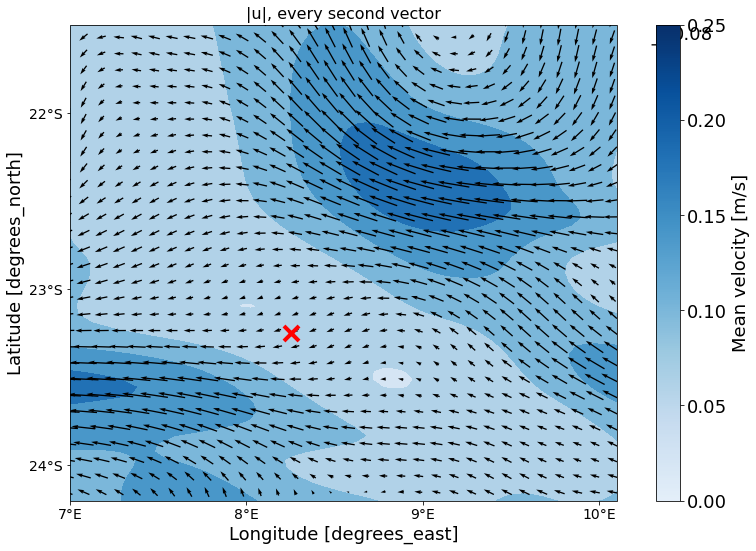

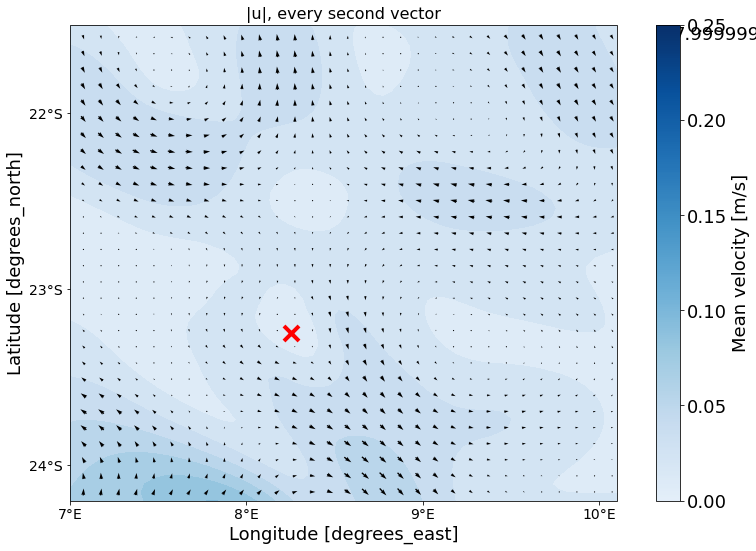

In [41]:
for i in [0,24]:
    fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(12, 8),
    )
    cf=plt.contourf(vel_quiver.nav_lon,vel_quiver.nav_lat,vel_quiver.isel(depth=i).vel,cmap=new_cmap,vmax=0.25)
    cb = plt.colorbar(ScalarMappable(norm=cf.norm, cmap=cf.cmap),label='Mean velocity [m/s]')
    q = vel_quiver.where(vel_quiver["vel"] > 0).isel(depth=i, x=slice(None, None, 2), y=slice(None, None, 2)).plot.quiver(
        ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=3, color="black", add_guide=True, zorder=1
    )
    #ax.quiverkey(q, 0.95, 1.02, 0.1, r'$0.1 \frac{m}{s}$',
    #                   coordinates='axes')
    #ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    #gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});
    ax.plot(8.25, -23.25, 'rx',markersize=15,markeredgewidth=4,zorder=3)
    ax.set_title(f"|u|, every second vector", size=16)
    ax.set_xticks([7,8,9,10])
    ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
    ax.set_yticks([-22,-23.,-24])
    ax.set_yticklabels(['22°S','23°S','24°S'],fontsize=14, family='Arial')

    plt.xlim([7,10.1])
    plt.ylim([-24.2,-21.5])
    
    plt.tight_layout();
    #plt.savefig(f"viking_2015-2019_{depth}m.png".format(depth=depth), dpi=300)

NameError: name 'depth' is not defined

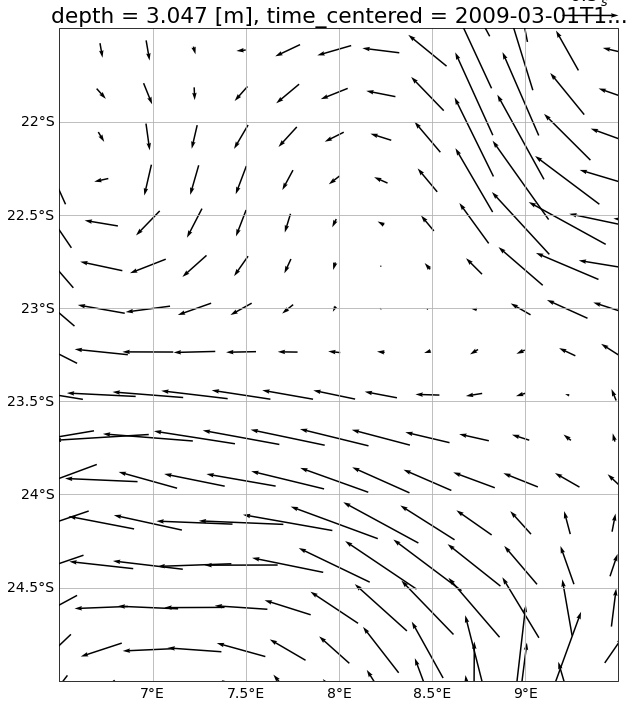

In [33]:
for i in [0,10,20,30]:
    fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(26, 12),
    )

    # vel["vel"].isel(depth=i).plot(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", 
    #     cmap=cmocean.cm.speed, cbar_kwargs={"label": "m/s"}
    # )
    # q = vel.isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 5)).plot.quiver(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale = 50, add_guide=True
    # )
    # ax.quiverkey(q, 1.03, 0.95, 1, r'$1 \frac{m}{s}$',
    #                    coordinates='axes')
    # ax.coastlines()
    # ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    # gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});
    # ax.add_feature(cartopy.feature.LAND, facecolor="lightgrey", zorder=1)
    
    #vel["vel"].isel(depth=i).where(mask==1).plot(
    #ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", levels=np.linspace(0, 1, 11),
    #cmap="Paired", cbar_kwargs={"label": "m/s"}, vmax=1
    #)
    #q2 = vel.where((vel["vel"] < 0.5) & (vel["vel"] > 0)).isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 10)).plot.quiver(
    #    ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=4, color="black", add_guide=True
    #)
    #ax.quiverkey(q2, 0.9, 1.02, 0.1, r'$0.1 \frac{m}{s}$',
    #                   coordinates='axes')

    q = vel.where(vel_quiver["vel"] > 0).isel(time_counter=0, depth=0,
                                              x=slice(None, None, 5), y=slice(None, None, 5)).plot.quiver(
        ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=1, color="black", add_guide=True, zorder=1
    )
    ax.quiverkey(q, 0.95, 1.02, 0.1, r'$0.5 \frac{m}{s}$',
                       coordinates='axes')
    ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});

    ax.set_title(f"|u|, depth=surface, every fifth vector".format(depth=depth), size=16);

    #plt.savefig(f"viking_2015-2019_{depth}m.png".format(depth=depth), dpi=300)

NameError: name 'depth' is not defined

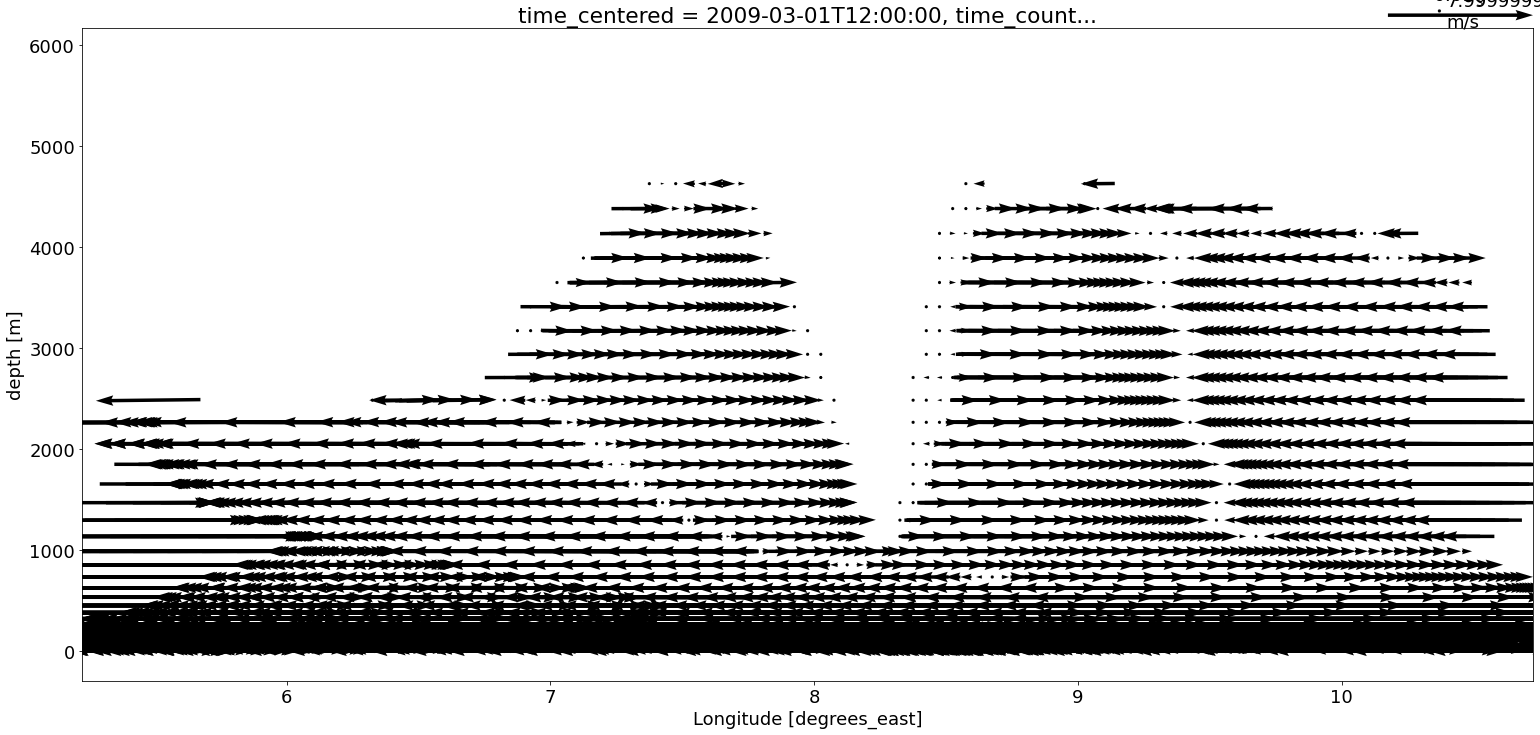

In [34]:
for i in [60]:
    fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
       # subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(26, 12),
    )

    # vel["vel"].isel(depth=i).plot(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", 
    #     cmap=cmocean.cm.speed, cbar_kwargs={"label": "m/s"}
    # )
    # q = vel.isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 5)).plot.quiver(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale = 50, add_guide=True
    # )
    # ax.quiverkey(q, 1.03, 0.95, 1, r'$1 \frac{m}{s}$',
    #                    coordinates='axes')
    # ax.coastlines()
    # ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    # gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});
    # ax.add_feature(cartopy.feature.LAND, facecolor="lightgrey", zorder=1)
    
    #vel["vel"].isel(depth=i).where(mask==1).plot(
    #ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", levels=np.linspace(0, 1, 11),
    #cmap="Paired", cbar_kwargs={"label": "m/s"}, vmax=1
    #)
    #q2 = vel.where((vel["vel"] < 0.5) & (vel["vel"] > 0)).isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 10)).plot.quiver(
    #    ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=4, color="black", add_guide=True
    #)
    #ax.quiverkey(q2, 0.9, 1.02, 0.1, r'$0.1 \frac{m}{s}$',
    #                   coordinates='axes')

    q = vel_w.where(vel_w["vel"] > 0).isel(time_counter=0, y=i, x=slice(None, None, 1), depth=slice(None, None, 1)).plot.quiver(
        ax=ax, x="nav_lon", y="depth", u="u", v="w", scale=0.1, color="black", add_guide=True, zorder=1
    )
    ax.quiverkey(q, 0.95, 1.02, 0.01, r'$0.01 \frac{m}{s}$',
                       coordinates='axes')
   # ax.set_extent([lon_left, lon_right, 0, 4000], crs=ccrs.PlateCarree())
   # gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});

    ax.set_title(f"|u|, nav_lat=-23.25".format(depth=depth), size=16);
    plt.gca().invert_yaxis()

    #plt.savefig(f"viking_2015-2019_{depth}m.png".format(depth=depth), dpi=300)

In [35]:
vel_w_mean=vel_w.mean('time_counter')

In [43]:
vel_w_plot

<xarray.Dataset>
Dimensions:        (depth: 46, x: 30)
Coordinates:
  * depth          (depth) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (x) float32 -23.24 -23.24 -23.24 ... -23.24 -23.24 -23.24
    nav_lon        (x) float32 7.475 7.525 7.575 7.625 ... 8.825 8.875 8.925
    time_centered  datetime64[ns] 2009-03-01T12:00:00
    time_counter   datetime64[ns] 2009-03-01T12:00:00
Dimensions without coordinates: x
Data variables:
    u              (depth, x) float32 -0.0535 -0.04955 -0.04578 ... 0.0 0.0 0.0
    v              (depth, x) float32 -0.001072 -0.0008466 -0.000587 ... 0.0 0.0
    w              (depth, x) float32 6.317e-08 6.507e-08 6.642e-08 ... nan nan
    vel            (depth, x) float32 0.05351 0.04956 0.04578 ... nan nan nan

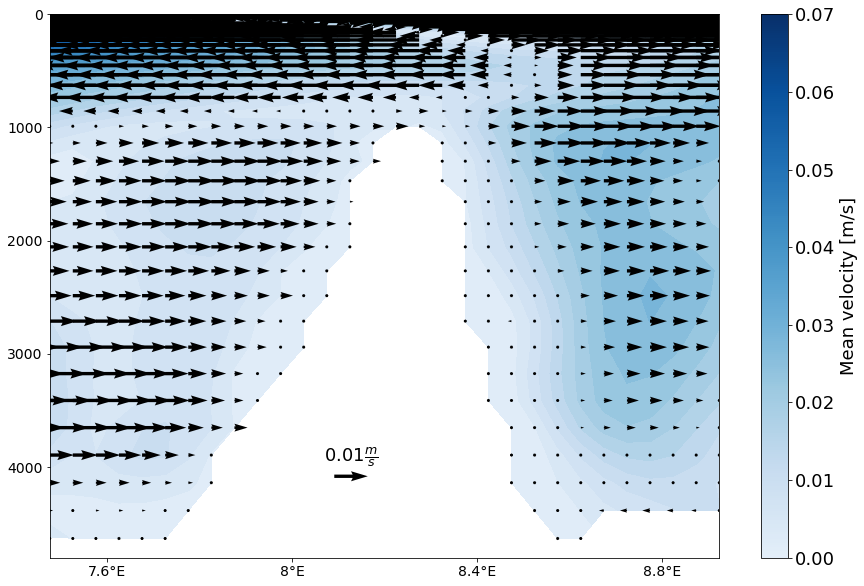

In [50]:
fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
        figsize=(15, 10),
    )
cf = plt.contourf(vel_w_plot['nav_lon'],-vel_w_plot['depth'],vel_w_plot.vel,levels=20,vmax=0.07,cmap=new_cmap)
cb = plt.colorbar(ScalarMappable(norm=cf.norm, cmap=cf.cmap),label='Mean velocity [m/s]')

q = plt.quiver(vel_w_mean.isel(y=60).nav_lon,-vel_w_mean.isel(y=60).depth,vel_w_mean.isel(y=60).u,vel_w_mean.isel(y=60).w,scale=0.2,width=0.005)

#vel_w.isel(time_counter=0, y=60, x=slice(None, None, 1), depth=slice(None, None, 1)).plot.quiver(
#        ax=ax, x="nav_lon", y="depth", u="u", v="w", scale=0.1, color="black", add_guide=True, zorder=1
#    )
plt.quiverkey(q, 0.45, 0.15, 0.01, r'$0.01 \frac{m}{s}$',
                       coordinates='axes')


#plt.gca().invert_yaxis()
plt.xticks([7.6,8,8.4,8.8],['7.6°E','8°E','8.4°E','8.8°E'],fontsize=14, family='Arial')
plt.yticks([-4000,-3000,-2000,-1000,0],[4000,3000,2000,1000,0],fontsize=14, family='Arial')

plt.xlim([7.475,8.925])
plt.ylim([-4800,0]);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


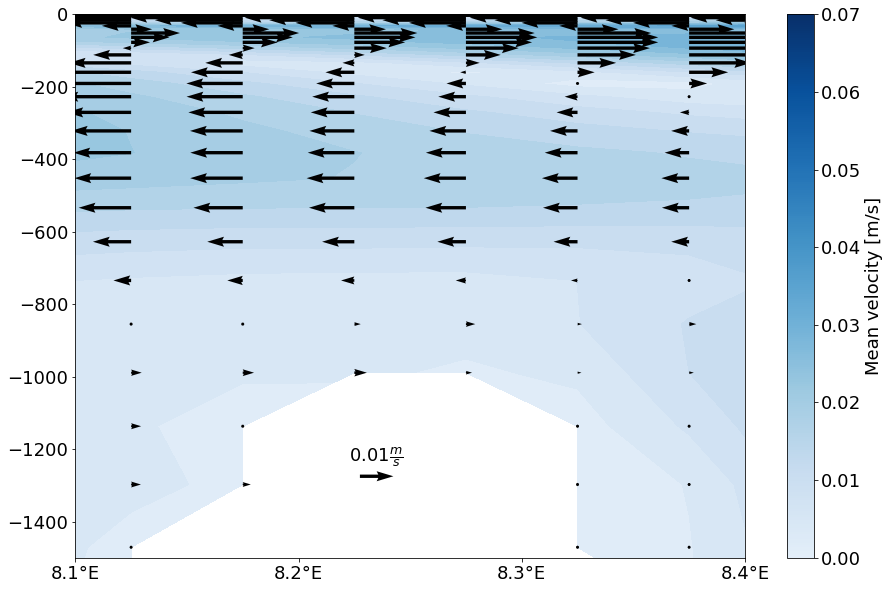

In [54]:
fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
        figsize=(15, 10),
    )
cf = plt.contourf(vel_w_plot['nav_lon'],-vel_w_plot['depth'],vel_w_plot.vel,levels=20,vmax=0.07,cmap=new_cmap)
cb = plt.colorbar(ScalarMappable(norm=cf.norm, cmap=cf.cmap),label='Mean velocity [m/s]')

q = plt.quiver(vel_w_mean.isel(y=60).nav_lon,-vel_w_mean.isel(y=60).depth,vel_w_mean.isel(y=60).u,vel_w_mean.isel(y=60).w,scale=0.2,width=0.005)

#vel_w.isel(time_counter=0, y=60, x=slice(None, None, 1), depth=slice(None, None, 1)).plot.quiver(
#        ax=ax, x="nav_lon", y="depth", u="u", v="w", scale=0.1, color="black", add_guide=True, zorder=1
#    )
plt.quiverkey(q, 0.45, 0.15, 0.01, r'$0.01 \frac{m}{s}$',
                       coordinates='axes')

plt.xticks([8.1,8.2,8.3,8.4],['8.1°E','8.2°E','8.3°E','8.4°E'],fontsize=18, family='Arial')
#plt.yticks([-1400,-1000,,0],[4000,3000,2000,1000,0],fontsize=14, family='Arial')

#plt.gca().invert_yaxis()
plt.xlim([8.1,8.4])
plt.ylim([-1500,0]);